In [1]:
%matplotlib inline

import numpy as np
import pylab as plt
import ccgpack as ccg

In [2]:
cl = np.loadtxt('../data/cl_planck_lensed')
sfs = ccg.StochasticFieldSimulator(cl)
nside = 1024
size = 20
ms = []

In [3]:
# for i in range(4):
#     ms.append(sfs.simulate(nside,size))
#     np.save('../data/simulations/sample_'+str(i),ms[-1])

In [4]:
for i in range(4):
    ms.append(np.load('../data/simulations/sample_'+
                      str(i)+'.npy'))

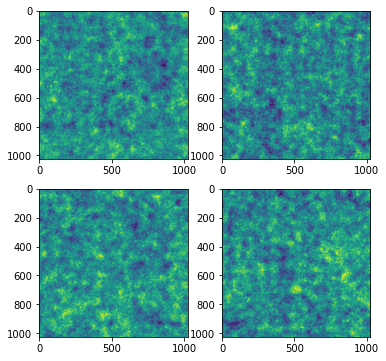

In [5]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(ncols=2
                            ,nrows=2,figsize=(6 ,6))
ax1.imshow(ms[0])
ax2.imshow(ms[1])
ax3.imshow(ms[2])
ax4.imshow(ms[3])

In [6]:
# ll0 = cl[:600,0]
# dl0 = cl[:600,1]*(ll0[:600]*(ll0[:600]+1)/(2*np.pi))
# ll,p1 = ccg.power_spectrum(ms[0],size=15)
# plt.plot(ll0,dl0,'k--')
# plt.plot(ll[:600],p1[:600],'b')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(2,600)
# # plt.ylim(5e-8,5e4)


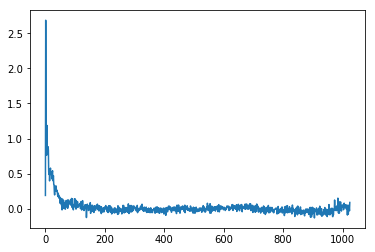

In [7]:
cor,ecor = ccg.correlarion_fucntion(ms[0],n_p=1e6)
plt.plot(cor)

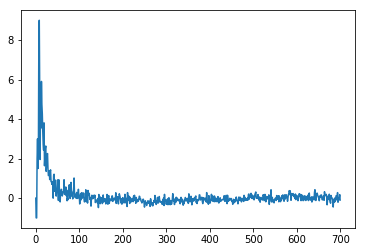

In [8]:
ksi = ccg.ppcf(ms[0],2,1e6,700)
plt.plot(ksi)

In [14]:
def bias(m,ths,kmin,kmax):
    
    if not isinstance(ths, list):
        ths = [ths]
    
    bs = []
    for th in ths:
        ksi = ccg.ppcf(m,th,1e6,700)
        biask = np.sqrt(np.absolute(ksi[:700]/cor[:700]))

        bs.append(np.mean(biask[kmin:kmax]))
              
    return bs

Text(0,0.5,'$b(\\nu)$')

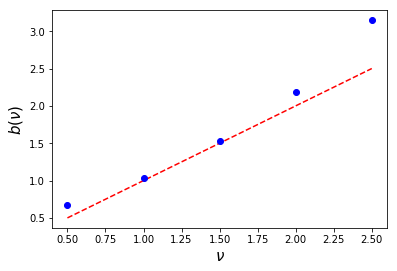

In [19]:
ths = [0.5,1.0,1.5,2.0,2.5]

kmin = 10
kmax = 50

bs = bias(ms[0],ths,kmin,kmax)

bsth = np.array(ths)
plt.plot(ths,bsth,'r--')

plt.plot(ths,bs,'bo')

plt.xlabel(r'$\nu$',fontsize=15)
plt.ylabel(r'$b(\nu)$',fontsize=15)